# Dataset generation

# Generating or loading points of interest (POIs)
The first step in the pipeline is getting a list of points of interest, defined by their coordinates (longitude, lattitude).
They can either be loaded from a file or randomly sampled from the planet, with the possibility of classifying and stratifying them.

# Loading from a file
The supported file formats are:
- CSV
- JSON
- GeoJSON
- KML
- XML

The file should be structured as a list of longitudes and latitudes, and prefferably a name.  
If the points in the file don't have an assigned name, it can be automatically generated using a provided prefix, using the format PREFIX-N, where N is the index of the row in the file.

## DataLoader usage
The DataLoader class can either be instantiated or used through the `load_to_dataframe()` static method, passing the file path and name prefix (if it's not present in the file itself).  
In the following example, we will be using a partner-provided (UNHCR) list of POIs, which already contains a name column.

In [1]:
%load_ext autoreload
%autoreload 2
from dataset_generation.DataLoader import DataLoader
path_to_file = 'dataset_generation/test_data/unhcr_formatted.csv'
pois = DataLoader.load_to_dataframe(path_to_file)
pois.head()

,unhcr_object_id,id_within_source,country_code,unhcr_global_poi_id,lat,lon,date,location_type,source,geometry
name,,,,,,,,,,
Olua 1,21,UGAs001848,UGA,{478F9142-EBB8-49B7-A2CE-73E30DCA8B00},3.302276,31.896969,1/31/1998,Refugees: settlement,OSU/UNHCR,POINT (31.896969 3.302276)
Posti,24,PAKs003525,PAK,{58BDD849-4207-4D6F-9A6A-02EF2A950319},29.248081,64.278532,2/3/2008,Refugees: settlement,OSU/UNHCR,POINT (64.278532 29.248081)
Saranan,25,PAKs003526,PAK,{4353F6A6-CB4E-4CED-BAF8-C8755FDA6EB6},30.535607,66.904866,2/3/2008,Refugees: settlement,OSU/UNHCR,POINT (66.904866 30.535607)
Surkhab,26,PAKs003527,PAK,{A40AEEC1-7667-482C-8CE9-4055F3ED6559},30.584363,67.088408,2/3/2008,Refugees: settlement,OSU/UNHCR,POINT (67.088408 30.584363)
Zar Karez,27,PAKs003528,PAK,{4C5FF8C2-8E13-4991-81DA-1052AC36BD6F},30.453032,68.433779,2/3/2008,Refugees: settlement,OSU/UNHCR,POINT (68.433779 30.453032)


## Generating POIs by uniformly sampling the planet
Through this project, we've used a combination of partner-provided (UNHCR, Amnesty and others) POIs, with a large number of randomly sampled points around the planet.  
Given a target number of points, the PlanetSampler class can be used to generate a list of such POIs.

Two sampling strategies are available:
- uniform on globe: uniformly sample the planet, oceans and all.
- exclude oceans: uniformly sample the planet, excluding the oceans, but including land water bodies.

In [2]:
from dataset_generation.PlanetSampler import PlanetSampler
sampler = PlanetSampler('exclude oceans', number_of_points=1000)
sampler.sampled_points.head()

c:\Users\ori\Desktop\0 WORLDSTRAT\repo\dataset_generation\PlanetSampler.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
Sampling points on the planet: 100%|██████████| 1000/1000 [00:00<00:00, 1504.53it/s]


,lon,lat
0,102.413443,53.781785
0,-73.555974,-14.025115
0,105.651806,43.348472
0,-165.672248,-85.284257
0,121.301875,-26.115240


In [3]:
sampler.visualise()

Visualising points on a map:   0%|          | 0/1000 [00:00<?, ?it/s]

# Problems with uniformly sampling the planet
When we sample the planet uniformly, for the purposes of a useful dataset, some issues arise:
- Antarctica is the fifth-largest continent in the world with a size of 14.2 million square kilometres.
- 71% of Earth's surface is water-covered, and the oceans make up about 96.5% of all Earth's water.
- 7% of the Earth's surface is covered by wetlands, with Canada alone haviing about 1.29 million km² of wetlands.

For this project, we had a budget of 10 000 km² of high-res imagery available.  
If we indeed uniformly sampled the Earth's surface and used those sampled points as centres of 2.5 km² AOIs, we would've ended up with:
- 7100 km² of water imagery, mostly oceans.

Let's ignore the oceans, we would still end up with:
- As much imagery of Antartctica's ice (8.9% landmass) as all European countries combined (6.7% landmass) and almost half of Australia + Oceania (5.2% landmass).
- Two times as much wetlands (7% landmass) as all urban areas in the world combined.

# What can be done about it?
We can stratify the points we've sampled using a number of different stratifying datasets:
- ESA Climate Change Initiative Land Cover (ESA CCI LC) dataset: 34 classes ranging from Agriculture and Forests to Permanent Ice and Snow.
- Intergovernmental Panel on Climate Change (IPCC) stratification: 6 broad classes (Agriculture, Forest, Grassland, Wetland, Settlement, Other).
- Global Human Settlement Model grid (GHSL S-MOD) settlement stratification: offers three density levels for three types of settlement stratification (Dense, Semi-dense, Low density - Urban, Suburban, Rural).

Using the above mentioned datasets, we can stratify our randomly sampled points to get a better understanding of what kind of areas they cover.  
With that insight, we can try to bump up certain areas, like built-up land areas, and decrease the amount of areas like permanent ice and snow, or water bodies.

Beside using our partner-provided POIs, we've tried to create a dataset that represents as much of the Earth's diversity while still being realistic and increasing focus on types of areas that are of broader interest to NGOs, researchers and other super-resolution projects.

# Stratifying the points
The Stratifier class can stratify a dataframe of POIs using the above three mentioned datasets.  
If the datasets aren't already downloaded and setup locally, it offers automatic downloading and preparation through the StratifierDatasets class, as well as manual instructions on how to do so.

The class also offers visualisation of the distribution of the classes from the three datasets within the set of the sampled points.

# Preparing the datasets
NOTE: if you haven't downloaded the ESA CCI LCCS and GLHS-SMOD datasets, you will need to follow the instructions at the bottom of the cell, when it throws out a warning.

The download links below can expire. If that happens, please generate a new one for Landcover by visiting:  
https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-land-cover?tab=form  
and pass it to the download_and_prepare_landcover_dataset() function. 

The code was written using the 2020 v2.1.1 version of the dataset.

In [5]:
# TODO: check if the stratification datasets exist and run this cell only if they don't
landcover_download_link="https://download-0008-clone.copernicus-climate.eu/cache-compute-0008/cache/data4/dataset-satellite-land-cover-b56f59cb-4b4c-4afc-aa77-bfea409fd697.zip?download"
smod=download_link="https://cidportal.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_SMOD_POP_GLOBE_R2019A/GHS_SMOD_POP2015_GLOBE_R2019A_54009_1K/V2-0/GHS_SMOD_POP2015_GLOBE_R2019A_54009_1K_V2_0.zip",
           
from dataset_generation.StratificationDatasets import StratificationDatasets
StratificationDatasets.download_and_prepare_landcover_dataset(download_link=landcover_download_link)
StratificationDatasets.download_and_prepare_smod_dataset()

Unzipping dataset_generation/stratification_datasets/landcover/landcover.zip to dataset_generation/stratification_datasets/landcover. This might take a minute.
Converting dataset_generation/stratification_datasets/landcover/C3S-LC-L4-LCCS-Map-300m-P1Y-2020-v2.1.1.nc to dataset_generation/stratification_datasets/landcover/C3S-LC-L4-LCCS-Map-300m-P1Y-2020-v2.1.1.tif using gdalwarp. This might take a few minutes.
dataset_generation/stratification_datasets/landcover/C3S-LC-L4-LCCS-Map-300m-P1Y-2020-v2.1.1.tif already exists. Skipping conversion.


Unzipping dataset_generation/stratification_datasets/smod/smod.zip to dataset_generation/stratification_datasets/smod. This might take a minute.


In [6]:
from dataset_generation.Stratifier import Stratifier
stratifier = Stratifier(sampler.sampled_points)
stratifier.points.head()


Determining landcover classes:   0%|          | 0/1000 [00:00<?, ?it/s]

Determining SMOD classes:   0%|          | 0/1000 [00:00<?, ?it/s]

,lon,lat,landcover_id,LCCS,IPCC,SMOD_id,SMOD
0,102.413443,53.781785,100,Mosaic tree and shrub (>50%) / herbaceous cove...,Forest,11,Rural: Very Low Dens
0,-73.555974,-14.025115,130,Grassland,Grassland,11,Rural: Very Low Dens
0,105.651806,43.348472,200,Bare areas,Other,11,Rural: Very Low Dens
0,-165.672248,-85.284257,220,Permanent snow and ice,None,11,Rural: Very Low Dens
0,121.301875,-26.115240,100,Mosaic tree and shrub (>50%) / herbaceous cove...,Forest,11,Rural: Very Low Dens


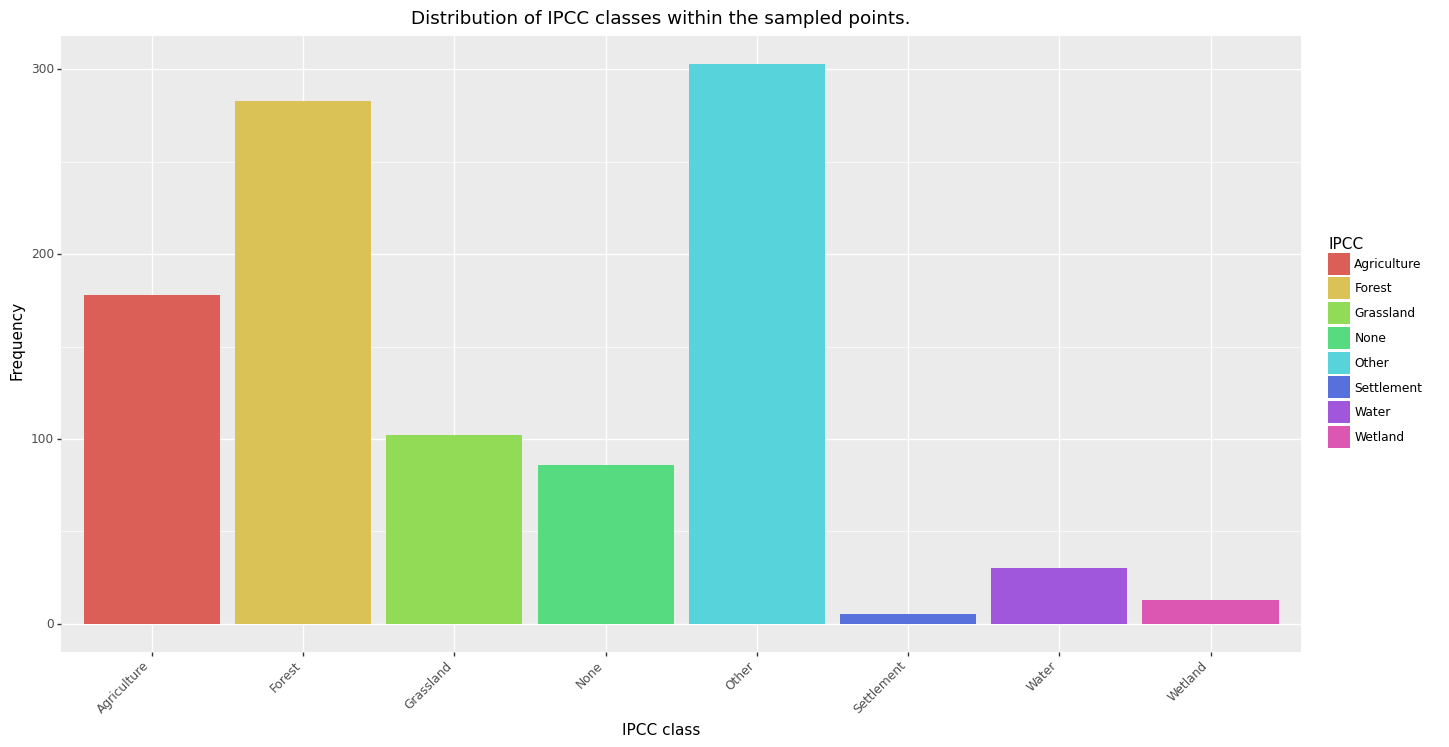

<ggplot: (183157672915)>

In [7]:
stratifier.visualise_IPCC_distribution()


# Using the classifications to stratify the sampled points
Since we have a limited high-resolution budget, we would like to increase the frequency of the less represented classes, and lower the frequency of the more represented classes.  
We can do so by applying a rebalancing function such as a square or cube root.

Sampling 5000 points to calculate the distribution with.


Sampling points on the planet: 100%|██████████| 5000/5000 [00:03<00:00, 1421.44it/s]

Stratifying the sampled distribution points.


Determining landcover classes:   0%|          | 0/5000 [00:00<?, ?it/s]

Determining SMOD classes:   0%|          | 0/5000 [00:00<?, ?it/s]

Calculating the original distributions.


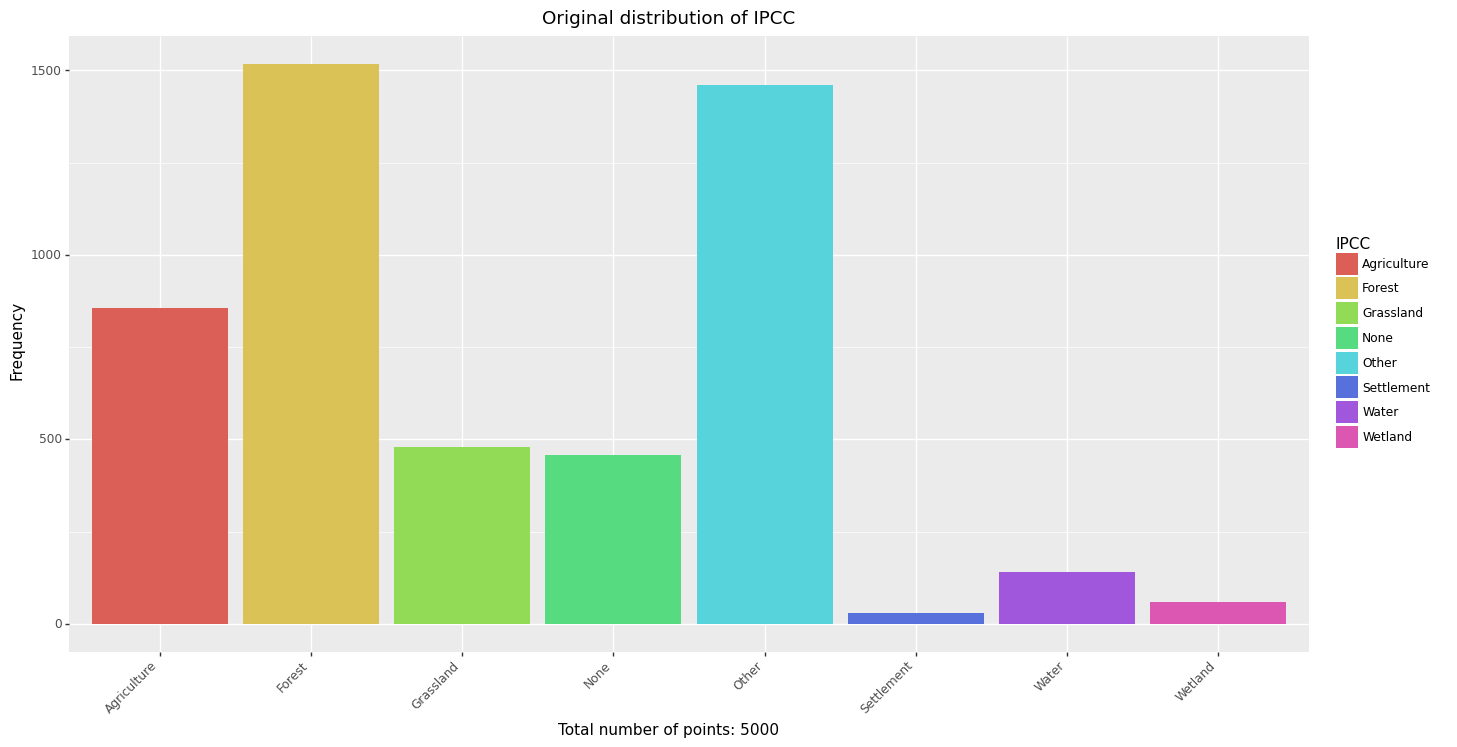

<ggplot: (183157317837)>

In [8]:
from dataset_generation.Rebalancer import Rebalancer
rebalancer = Rebalancer(number_of_points_to_sample=100, number_of_points_calculate_the_distributions=5000)
rebalancer.visualise_original_distribution('IPCC')

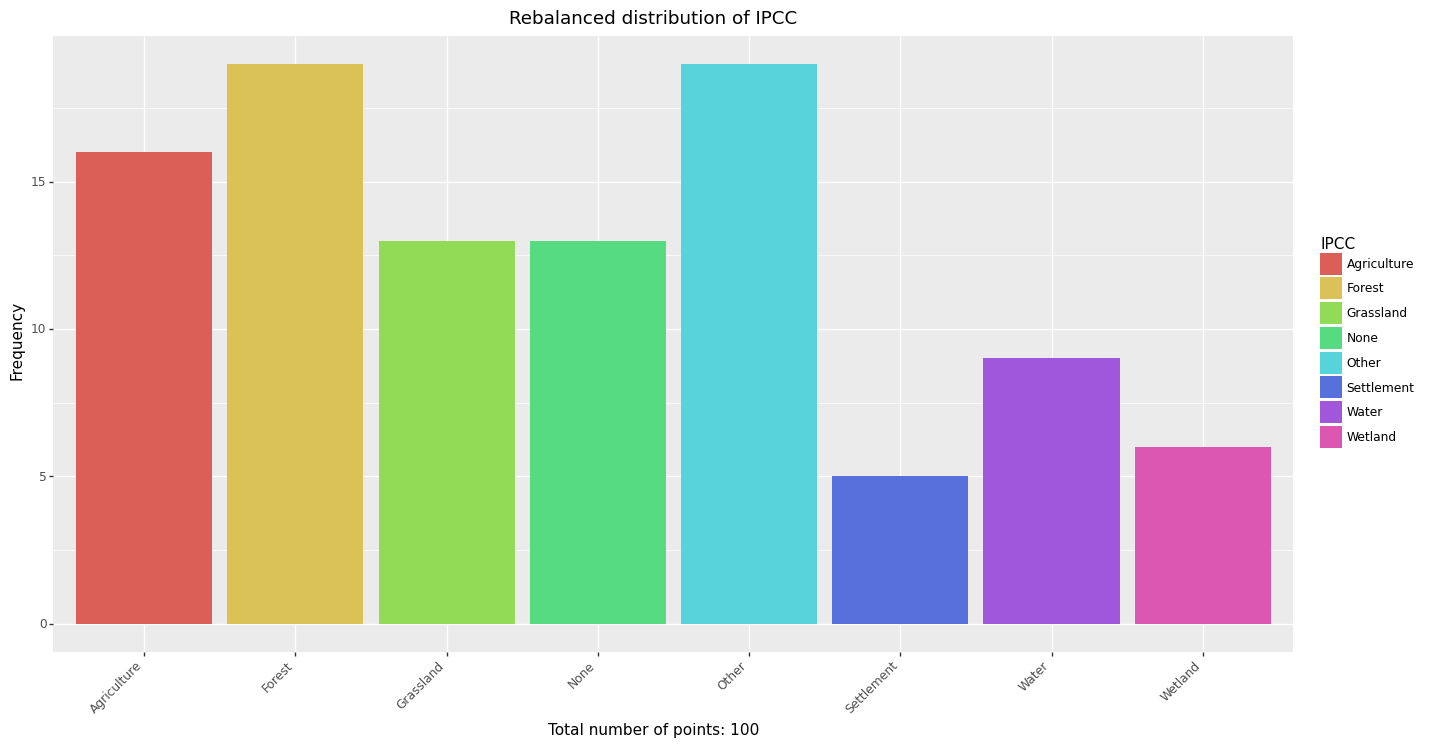

<ggplot: (183157528275)>

In [9]:
from numpy import cbrt as cube_root, sqrt as square_root
rebalancer.rebalance_original_distributions(rebalancing_function=cube_root)
rebalancer.visualise_rebalanced_distribution('IPCC')

# Substratifying and rebalancing

Taking the example of the Settlement class in the IPCC classification, we might want to dive deeper and rebalance the frequency of the three SMOD classes within the IPCC Settlement class.  
The Rebalancer class provides an easy way to do so as well.

In [10]:
rebalancer.rebalance_within_class('IPCC', 'Settlement', 'SMOD', square_root, 18)

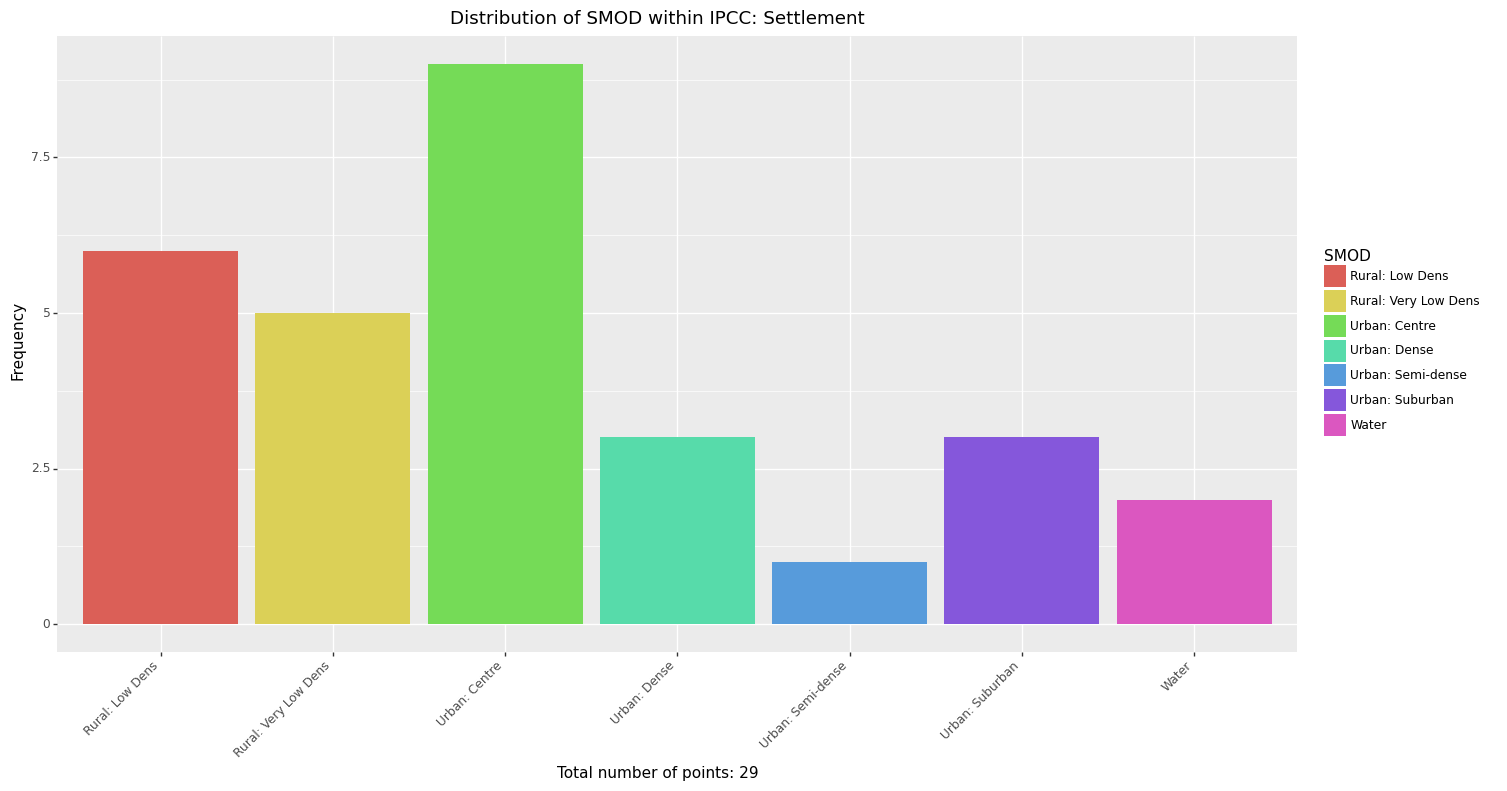

<ggplot: (183212385524)>

In [11]:
rebalancer.visualise_original_distribution('IPCC_Settlement_SMOD')

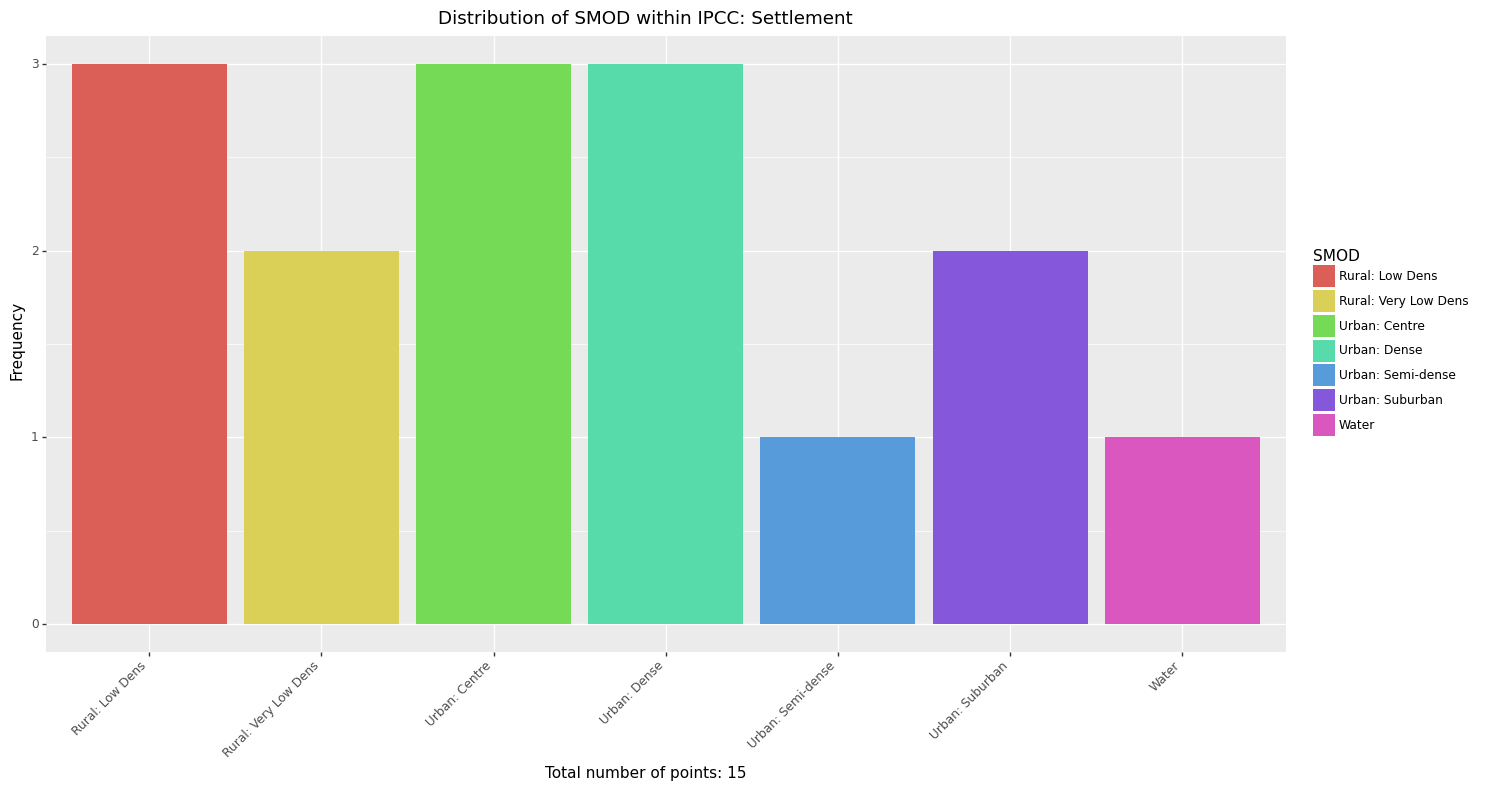

<ggplot: (183211730110)>

In [12]:
rebalancer.visualise_rebalanced_distribution('IPCC_Settlement_SMOD')

In [13]:
classification_dataset = 'SMOD'
distribution = rebalancer.rebalanced_distributions['IPCC_Settlement_SMOD']
rebalancer.sample_distribution(
    classification_dataset, distribution)


,lon,lat,landcover_id,LCCS,IPCC,SMOD_id,SMOD
0,87.133293,26.056683,20,"Cropland, irrigated or post‐flooding",Agriculture,12,Rural: Low Dens
0,-2.718016,8.046710,62,"Tree cover, broadleaved, deciduous, open (15‐40%)",Forest,12,Rural: Low Dens
0,104.238382,28.738980,70,"Tree cover, needleleaved, evergreen, closed to...",Forest,12,Rural: Low Dens
0,47.332252,15.066846,200,Bare areas,Other,11,Rural: Very Low Dens
0,27.119187,-26.786133,130,Grassland,Grassland,11,Rural: Very Low Dens
0,121.506498,37.409250,10,"Cropland, rainfed",Agriculture,30,Urban: Centre
0,46.601859,43.277970,10,"Cropland, rainfed",Agriculture,30,Urban: Centre
0,31.326738,30.906613,20,"Cropland, irrigated or post‐flooding",Agriculture,30,Urban: Centre
0,115.317293,38.285624,11,Herbaceous cover,Agriculture,23,Urban: Dense
0,23.289101,24.211351,190,Urban areas,Settlement,23,Urban: Dense


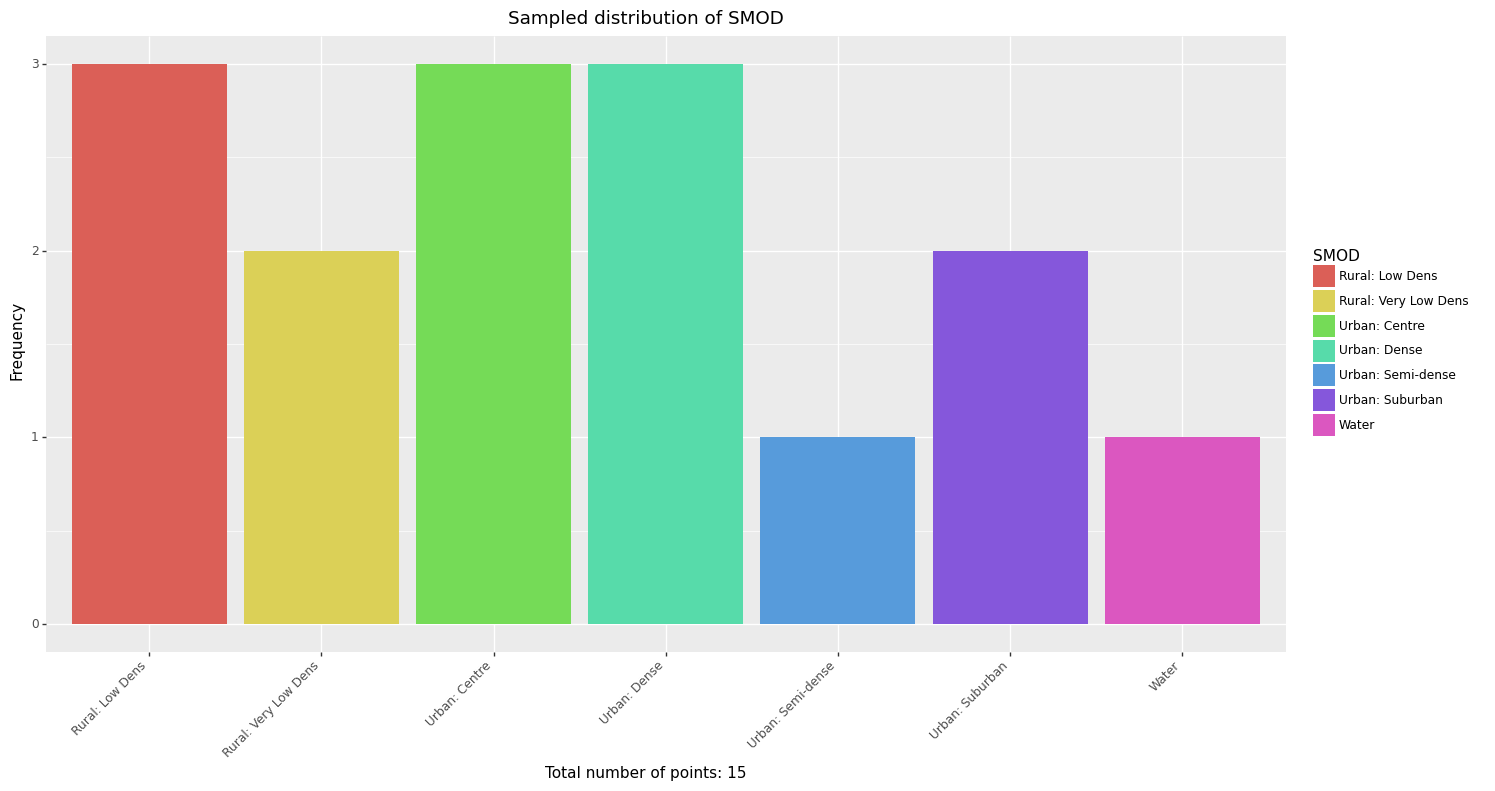

<ggplot: (183157305104)>

In [14]:
rebalancer.visualise_sampled_distribution('SMOD')

In [15]:
from dataset_generation.AOIGenerator import AOIGenerator
aoi_generator = AOIGenerator(rebalancer.sampled_points, aoi_area_sqkm=2.5, aoi_name_prefix='RandomlySampled')
aoi_generator.aois.head()

Generating AOIs:   0%|          | 0/15 [00:00<?, ?it/s]

,lon,lat,landcover_id,LCCS,IPCC,SMOD_id,SMOD,name,bounds,area
0,87.133293,26.056683,20,"Cropland, irrigated or post‐flooding",Agriculture,12,Rural: Low Dens,RandomlySampled-0,"[87.1253932516718, 26.04954716619207, 87.14119...",2.5
0,-2.718016,8.046710,62,"Tree cover, broadleaved, deciduous, open (15‐40%)",Forest,12,Rural: Low Dens,RandomlySampled-0,"[-2.725187713084265, 8.039561271845967, -2.710...",2.5
0,104.238382,28.738980,70,"Tree cover, needleleaved, evergreen, closed to...",Forest,12,Rural: Low Dens,RandomlySampled-0,"[104.23028871496895, 28.731847293172642, 104.2...",2.5
0,47.332252,15.066846,200,Bare areas,Other,11,Rural: Very Low Dens,RandomlySampled-0,"[47.32489929435795, 15.059700820900948, 47.339...",2.5
0,27.119187,-26.786133,130,Grassland,Grassland,11,Rural: Very Low Dens,RandomlySampled-0,"[27.111236790048075, -26.793268491763296, 27.1...",2.5


In [16]:
aoi_generator.visualise_generated_aois()

# Setting up SentinelHub credentials

If you don't have a SentinelHub account, [you can get a free 30-day trial account here](https://www.sentinel-hub.com/trial).

After registering, you need to create an OAuth client in [the Account Settings dashboard](https://apps.sentinel-hub.com/dashboard/#/account/settings), on the bottom right.

Once you've got your client secret and ID, open up a terminal, and run:
```bash
sentinelhub.config --sh_client_id "YOUR_CLIENT_ID" 
sentinelhub.config --sh_client_secret "YOUR_CLIENT_SECRET"
```

And you should be good to continue running the rest of the notebook.

# Searching the SentinelHub catalogues for revisits
Once we have our AOIs, we can search SentinelHub's catalogue for available Sentinel2 and SPOT imagery/revisits.  
We can do this by simply passing the AOIs into the SentinelCatalogue and SPOTCatalogue classes.

When searching for available imagery, we can also define the time window within whom we'd like our revisits to be,  
but we can also get everything and filter the data afterwards using the CatalogueFilter class.

## Searching for Sentinel-2 revisits
Let's start by searching for available Sentinel-2 revisits.

In [ ]:
from dataset_generation.SentinelCatalogue import SentinelCatalogue
catalogue = SentinelCatalogue(aoi_generator.aois)
catalogue.sentinel2_catalogue.head()


## Visualising the overlap between the available Sentinel-2 revisits and our AOIs

The available revisits sometimes do not overlap perfectly with our AOIs, which the CatalogueFilter class automatically  
checks for by computing the intersection area between the two, with the possibility of filtering by some threshold.

But this is also a nice way to visually verify that our catalogue results make sense.

In [ ]:
catalogue.visualise_catalog_coverage()

# Searching for SPOT revisits
Searching for SPOT revisits is just as simple as searching for Sentinel-2 revisits.

In [ ]:
from dataset_generation.SPOTCatalogue import SPOTCatalogue
spot_catalogue = SPOTCatalogue(aoi_generator.aois)
spot_catalogue.spot_catalogue.head()

## Visualising the overlap between the available SPOT revisits and our AOIs

The available revisits sometimes do not overlap perfectly with our AOIs, which the CatalogueFilter class automatically  
checks for by computing the intersection area between the two, with the possibility of filtering by some threshold.

But this is also a nice way to visually verify that our catalogue results make sense.

In [ ]:
spot_catalogue.visualise_catalog_coverage()

# Filtering the available revisits

Once we've found our Sentinel-2 and SPOT revisits, we can filter them by a variety of parameters, most importantly by:
- The distance from the revisits to the target date in days (delta days).
- The amount of predicted cloud cover on the revisits (in %).

The distance in days can be either a positive or a negative value, meaning the revisits can be after or before the target date.  

The predicted cloud cover percentage is provided to us by the data provider, and it is computed over the entire product scene.  
The product scene is often a much larger area than the typical AOI area (in our case 2.5 km²), so it should be taken with a grain of salt.  
We could have a relatively small cloud cover percentage, and end up with a completely cloudy revisit if we're unlucky, and vice versa.

## Ranking the revisits by their "quality"

The `CatalogueFilter` class allows us to rank the revisits based on what's most important to us:
- The distance in days from the target date (delta days), or
- The amount of cloud cover in the revisit product

The ranking is a simple numerical rank. Using cloud cover as the example: the revisit with the least amount of cloud cover   
is ranked 1 out of all the revisits, and the revisit with the largest amount of cloud cover is ranked last.

The ranks are computed for both delta days and cloud cover, and then combined into a single rank using the formula:  
`delta_rank * delta_importance + cloud_cover_rank * cloud_cover_importance`, for each revisit.

The revisits are then sorted by their rank, and the best N revisits are taken, with N being the target number of revisits.  
The ranking system might not be perfect, but it works reasonably well, and it can be replaced with any other way of selecting  
the "best" revisits in the `filter_aois` function in the `CatalogueFilter` class.

The filter takes the following arguments:
- cloud_cover_importance: the importance factor relative to delta days, by default 1
- delta_importance: the importance factor relative to the cloud cover, by default 1
- n_target_revisits: the target/wanted number of revisits by default 8
- max_cloud_cover_percentage: the absolute maximum amount of cloud cover (in %) allowed, by default None
- max_delta_days: the absolute maximum distance in days from the target date a revisit is allowed to be, by default None

## Filtering the Sentinel-2 revisits

In [ ]:
from dataset_generation.CatalogueFilter import CatalogueFilter
sentinel_catalogue_filter = CatalogueFilter(aoi_generator.aois, catalogue.sentinel2_catalogue, target_date='22-03-2022')
sentinel_catalogue_filter.filtered_catalogue.head(3)

## Visualising the filtered Sentinel-2 revisits

In [ ]:
sentinel_catalogue_filter.visualise_filtered_catalogue()

## Visualising the delta days for the filtered Sentinel-2 revisits

In [ ]:
sentinel_catalogue_filter.visualise_delta_days()

## Filtering the SPOT revisits

In [ ]:
from dataset_generation.CatalogueFilter import CatalogueFilter
from tqdm.notebook import tqdm
spot_catalogue_filter = CatalogueFilter(
    aoi_generator.aois, spot_catalogue.spot_catalogue, target_date='21-03-2021', n_target_revisits=1)
spot_catalogue_filter.filtered_catalogue


## Visualising the filtered SPOT revisits

In [ ]:
spot_catalogue_filter.visualise_filtered_catalogue()


# Downloading Sentinel-2 imagery

Once we have selected our revisits, we can download the Sentinel-2 imagery using SentinelHub by  
just passing the original AOIs and the selected revisits to the `SentinelDownloader` class.

The imagery is by default downloaded to `data\downloads\Sentinel2`.

In [ ]:
from dataset_generation.SentinelDownloader import SentinelDownloader
sentinel_downloader = SentinelDownloader(
    aoi_generator.aois, sentinel_catalogue_filter.filtered_catalogue, overwrite=True)


## Visualising the downloaded Sentinel2 imagery

The `SentinelDownloader` class has a built-in visualisation method for the downloaded imagery.  

By default, it returns an interactive IPython widget with a slider that scrolls through all the downloaded images.  
If the `save_gif` parameter is set to `True`, then the method saves the visualisation  
as a GIF in `data\visualisations\s2_revisits.gif` and previews it in the notebook.

In [ ]:
sentinel_downloader.visualise_downloaded_revisits(save_gif=True)

# Ordering SPOT imagery

Unlike Sentinel-2 imagery, SPOT imagery is not freely available.  
This means we have to order it from Airbus and of course, pay for it.  

SentinelHub makes this easy, and the proces is as follows:
- We create a collection on SentinelHub that serves as a collection of orders.
- We create an order by giving SentinelHub the selected SPOT revisit (containing the AOI bounds and product id).
- We confirm the order, which uses the budget from our SentinelHub account.
- We wait for the order to be processed and fullfilled (by Airbus).
- We can download the imagery either through SentinelHub or directly from Airbus.

## Creating demo orders

In [ ]:
from dataset_generation.SPOTOrder import SPOTOrder
spot_order = SPOTOrder(spot_catalogue_filter.filtered_catalogue, 'demo_collection')
spot_order.create_orders()
spot_order.visualise_created_orders()


If you've already got a collection with some orders, you view the rest of it's orders by calling
`spot_order.visualise_all_orders()`.

## Confirming the orders

Once the orders are created, and after visually verifying they're correct, we can confirm them by calling `confirm_orders`.  
The `confirm_orders` method has a safety variable that prevents accidental order confirmation (e.g. by rerunning the notebook).  

If the safety variable (`actually_confirm_orders`) is set to `False`, the method returns a dummy data frame with the order ids.

In [ ]:
spot_order.confirm_orders()

# Deleting the demo collection

We can delete the demo collection by running the cell below.

In [ ]:
SPOTOrder.delete_collection(spot_order.collection_id)

# Downloading SPOT imagery

Once you've confirmed all of your orders, and they've been fulfilled by Airbus, you can use the `SPOTDownloader` class  
to download the imagery from the collection.

In [ ]:
# Get all orders from a collection
collection_id = '679ca7dc-a31d-473d-b951-dc5f917fdf1a' # Landcover
collection_orders = SPOTOrder.get_all_orders_for_collection(collection_id)

In [ ]:
SPOTDownloader.get_downloaded_revisits_paths("data/downloads/SPOT/")

In [ ]:
from dataset_generation.SPOTDownloader import SPOTDownloader
from IPython.display import Image
SPOTDownloader.download_spot_for_orders(collection_orders.head(3))
SPOTDownloader.visualise_downloaded_revisits(save_gif=True)
Image('data/visualisations/spot_revisits.gif')

# Alternatively, you can use the following to download all orders for a collection:
# SPOTDownloader.download_spot_for_entire_collection(collection_id)

## Image size limit on SentinelHub API

For some reason, the maximum image size that can be requested through the SentinelHub API is 2500x2500, which means that  
for larger AOIs, e.g. 22.5 km² like we have for ASMSpotter and Micah AOIs, the pan-chromatic channel can't be downloaded  
in it's full native resolution of 1.5 metres per pixel, which would be 3162x3162 px.

The `SPOTDownloader` class offers a solution for this: split the larger AOI into n-tiles and download them `split_order_into_tiles`.

We split our ASMSpotter and Micah AOIs into nine 2.5 km² tiles, and download them separately in their full native resolution.

In [ ]:
SPOTDownloader.visualise_downloaded_revisits(save_gif=True)
Image('data/visualisations/spot_revisits.gif')